In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle

import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wandb

from jax import jit, vmap, random

from src.net import NetworkTrainerWandB
from src.data import load_riser_data, get_X_y, split_curve

# Data

In [3]:
df_riser = load_riser_data('data/riser.csv')
df_riser

,psup,rgl,bsw,qliq,delta_p
0,10.0,50.000000,0.010000,300.0,98.266316
1,10.0,50.000000,0.061579,300.0,98.800564
2,10.0,50.000000,0.113158,300.0,99.743402
3,10.0,50.000000,0.164737,300.0,100.252045
4,10.0,50.000000,0.216316,300.0,101.191013
...,...,...,...,...,...
142982,60.0,585.897436,0.267895,6500.0,449.306072
142983,60.0,610.256410,0.010000,6500.0,432.506369
142984,60.0,610.256410,0.061579,6500.0,438.928311
142985,60.0,610.256410,0.113158,6500.0,445.509859


In [4]:
df_train, df_test = split_curve(df_riser, 0.5)
df_train.shape, df_test.shape

((9068, 5), (133911, 5))

In [5]:
df_train.nunique()

psup          5
rgl          20
bsw          10
qliq         10
delta_p    9067
dtype: int64

# ReLU

## Medium

In [6]:
X, y= get_X_y(df_riser)
X_train, y_train = get_X_y(df_train)
X_test, y_test = get_X_y(df_test)

In [7]:
with open('medium_nn_hp_tuning_results.pkl', 'rb') as f:
    hp_results = pickle.load(f)

len(hp_results)

56

In [8]:
results_for_df = list()
for hp_result in hp_results:
    result_for_df = dict(epoch=hp_result['epochs'], time=hp_result['time'], **hp_result['hps'])
    result_for_df['val_results'] = np.mean(hp_result['val_results'])
    result_for_df['train_results'] = np.mean(hp_result['train_results'])
    results_for_df.append(result_for_df)
df_hp_results = pd.DataFrame(results_for_df)

df_hp_results.sort_values(by='val_results').head()

,epoch,time,h_layers,h_units,learning_rate,val_results,train_results
55,5000,5529.103943,5,200,0.001,3.686937,2.344945
16,5000,9913.874577,10,200,0.001,4.695343,3.183174
47,5000,2772.558454,2,200,0.001,4.760403,3.432030
40,5000,2696.318245,5,100,0.001,6.207915,5.444983
37,5000,2749.746311,2,200,0.010,6.636134,5.874952


/home/bruno/miniconda3/envs/relu/lib/python3.11/site-packages/jax/_src/random.py:399: FutureWarning: jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
  warnings.warn(msg, FutureWarning)
ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: brunompac. Use `wandb login --relogin` to force relogin


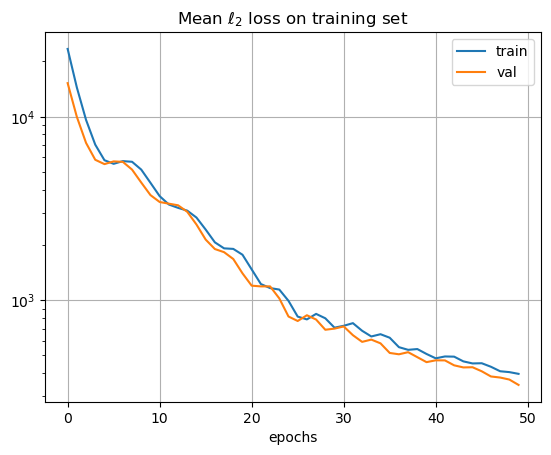

Test performance
MAE = 19.929136
max error = 111.52341


In [9]:
net = NetworkTrainerWandB(h_layers=5, h_units=100, random_key=2,
                          learning_rate=1e-3, epochs=50)

net = net.fit(
    X_train, y_train,
    X_val=X_test, y_val=y_test,
    wandb_project='relu-pwl',
    # wandb_notes='Best model from first hp tuning.',
    wandb_group='TEST',
)

plt.plot(net.train_loss_values_, label='train')
plt.plot(net.val_loss_values_, label='val')
plt.yscale('log')
plt.xlabel('epochs')
plt.title('Mean $\ell_2$ loss on training set')
plt.legend()
plt.grid()
plt.show()

y_hat = net.predict(X_test)

df_test['delta_p_hat'] = y_hat

percentage_error = y_hat[:,0] - df_test['delta_p'].values

print('Test performance')
print('MAE =', np.abs(percentage_error).mean())
print('max error =', np.abs(percentage_error).max())

In [12]:
net.save('models/test_nn.pkl')

In [13]:
net = NetworkTrainerWandB.load('models/test_nn.pkl')

In [30]:
y_hat = net.predict(X_train)

df_train['delta_p_hat'] = y_hat

y = df_train['delta_p'].values
percentage_error = 100*(y_hat[:,0] - y) / y

print('Training performance')
print(f'MAPE = {np.abs(percentage_error).mean():.4f} % (std={np.abs(percentage_error).std():.4f} p.p.)')
print('max error =', np.abs(percentage_error).max(),'%')

Training performance
MAPE = 1.3503 % (std=2.0264 p.p.)
max error = 21.57083 %


In [31]:
y_hat = net.predict(X)

df_riser['delta_p_hat'] = y_hat

y = df_riser['delta_p'].values
percentage_error = 100*(y_hat[:,0] - y) / y

print('Full curve performance')
print(f'MAPE = {np.abs(percentage_error).mean():.4f} % (std={np.abs(percentage_error).std():.4f} p.p.)')
print('max error =', np.abs(percentage_error).max(),'%')

Full curve performance
MAPE = 1.5422 % (std=2.4011 p.p.)
max error = 23.675787 %


## Curves

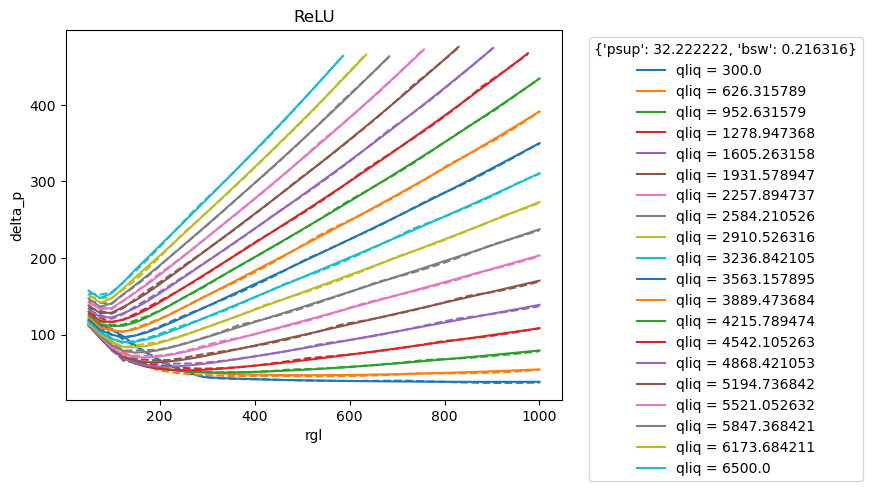

In [43]:
fixed_point = {
    'psup': 32.222222,
    'bsw': 0.216316,
}

df_ = df_riser[(df_riser['psup'] == fixed_point['psup']) & (df_riser['bsw'] == fixed_point['bsw'])]

for val in df_['qliq'].unique():
    df__ = df_[df_['qliq'] == val]
    p = plt.plot(df__['rgl'], df__['delta_p'], label=f"qliq = {val}")
    plt.plot(df__['rgl'], df__['delta_p_hat'], '--', color=p[0].get_color())
plt.xlabel('rgl')
plt.ylabel('delta_p')
plt.title(fixed_point)
plt.title('ReLU')
plt.legend(title=fixed_point, bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

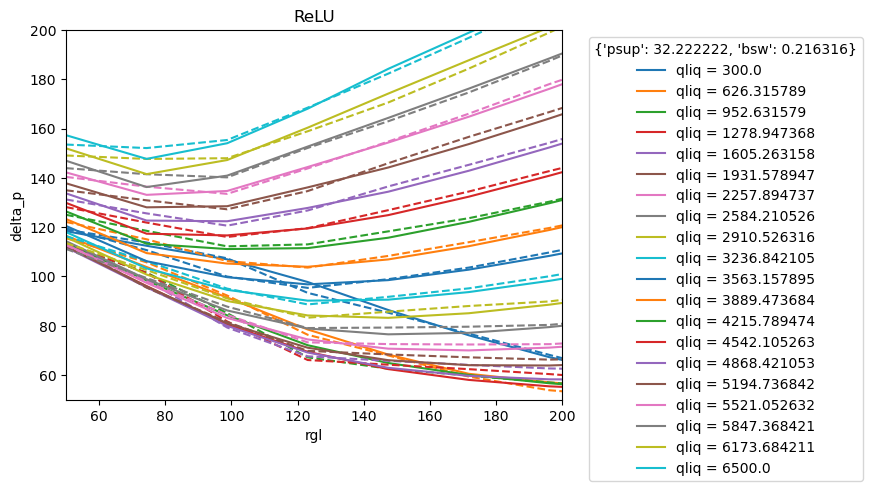

In [42]:
fixed_point = {
    'psup': 32.222222,
    'bsw': 0.216316,
}

df_ = df_riser[(df_riser['psup'] == fixed_point['psup']) & (df_riser['bsw'] == fixed_point['bsw'])]

for val in df_['qliq'].unique():
    df__ = df_[df_['qliq'] == val]
    p = plt.plot(df__['rgl'], df__['delta_p'], label=f"qliq = {val}")
    plt.plot(df__['rgl'], df__['delta_p_hat'], '--', color=p[0].get_color())
plt.xlabel('rgl')
plt.ylabel('delta_p')
plt.title(fixed_point)
plt.ylim(50,200)
plt.xlim(50,200)
plt.title('ReLU')
plt.legend(title=fixed_point, bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

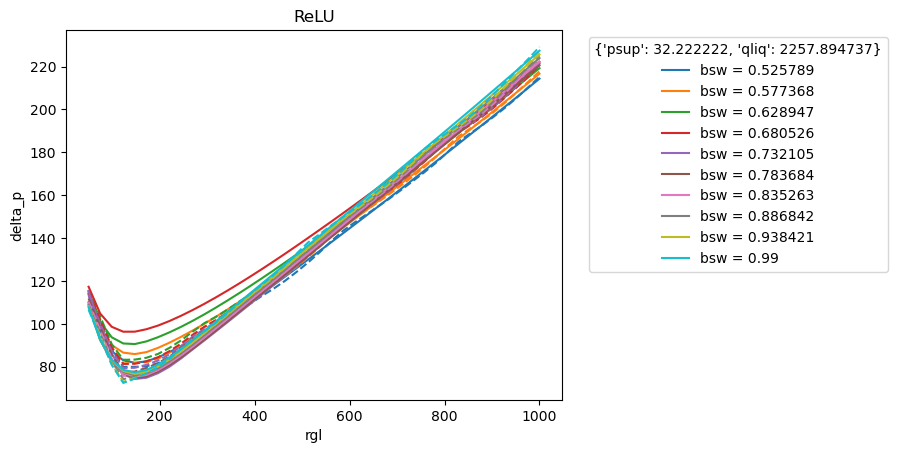

In [41]:
fixed_point = {
    'psup': 32.222222,
    'qliq': 2257.894737,
}

df_ = df_riser[(df_riser['psup'] == fixed_point['psup']) & (df_riser['qliq'] == fixed_point['qliq'])]

for val in df_['bsw'].unique():
    if val < .5:
        continue
    df__ = df_[df_['bsw'] == val]
    p = plt.plot(df__['rgl'], df__['delta_p'], label=f"bsw = {val}")
    plt.plot(df__['rgl'], df__['delta_p_hat'], '--', color=p[0].get_color())
plt.xlabel('rgl')
plt.ylabel('delta_p')
plt.title('ReLU')
plt.legend(title=fixed_point, bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

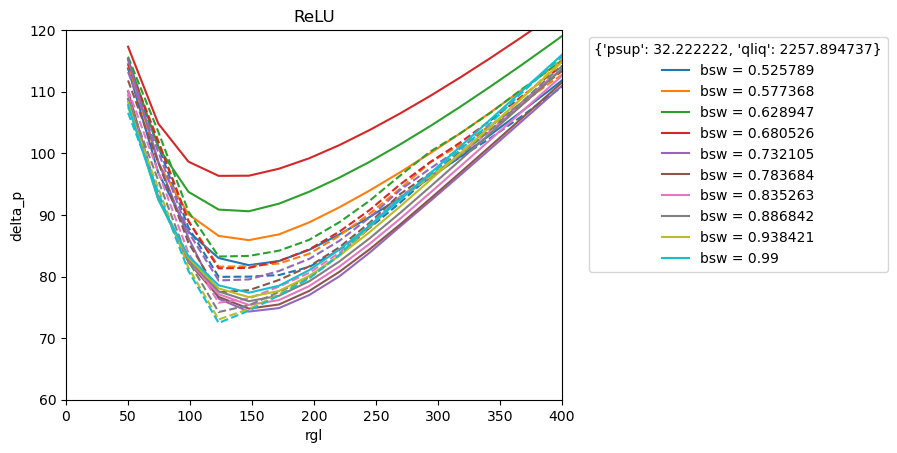

In [44]:
fixed_point = {
    'psup': 32.222222,
    'qliq': 2257.894737,
}

df_ = df_riser[(df_riser['psup'] == fixed_point['psup']) & (df_riser['qliq'] == fixed_point['qliq'])]

for val in df_['bsw'].unique():
    if val < .5:
        continue
    df__ = df_[df_['bsw'] == val]
    p = plt.plot(df__['rgl'], df__['delta_p'], label=f"bsw = {val}")
    plt.plot(df__['rgl'], df__['delta_p_hat'], '--', color=p[0].get_color())
plt.xlabel('rgl')
plt.ylabel('delta_p')
plt.title(fixed_point)
plt.title('ReLU')
plt.legend(title=fixed_point, bbox_to_anchor=(1.04, 1), loc="upper left")
plt.ylim(60,120)
plt.xlim(0,400)
plt.show()

# PWL

In [23]:
from src.pwl import PWL

In [24]:
model = PWL()
model.fit(df_train)

y_hat = model(df_train)

assert (df_train['delta_p'].values == y_hat).all()
assert not np.isnan(y_hat).any()

In [25]:
%time y_hat = model(df_test)

np.isnan(y_hat).sum() / len(y_hat)

CPU times: user 1.24 s, sys: 323 ms, total: 1.57 s
Wall time: 43.9 s


0.0291387563381649

In [29]:
y_hat = model(df_test)

y = df_test['delta_p'].values
percentage_error = 100*(y_hat - y) / y
percentage_error = percentage_error[~np.isnan(percentage_error)]

print('Test performance')
print(f'MAPE = {np.abs(percentage_error).mean():.4f} % (std={np.abs(percentage_error).std():.4f} p.p.)')
print('max error =', np.abs(percentage_error).max(),'%')

Test performance
MAPE = 0.8936 % (std=2.1536 p.p.)
max error = 27.730489731099876 %


In [28]:
y_hat = model(df_riser)

y = df_riser['delta_p'].values
percentage_error = 100*(y_hat - y) / y
percentage_error = percentage_error[~np.isnan(percentage_error)]

df_riser['delta_p_hat'] = y_hat

print('Full curve performance')
print(f'MAPE = {np.abs(percentage_error).mean():.4f} % (std={np.abs(percentage_error).std():.4f} p.p.)')
print('max error =', np.abs(percentage_error).max(),'%')

Full curve performance
MAPE = 0.8354 % (std=2.0939 p.p.)
max error = 27.730489731099876 %


## Curves

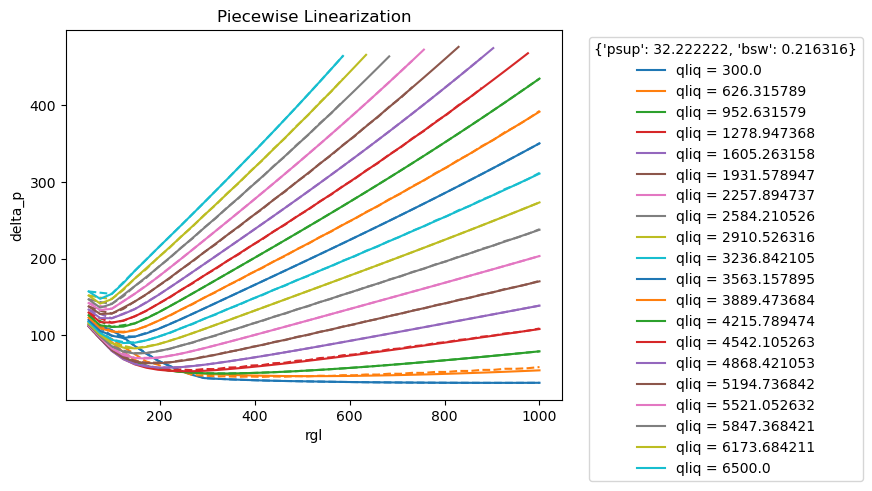

In [52]:
fixed_point = {
    'psup': 32.222222,
    'bsw': 0.216316,
}

df_ = df_riser[(df_riser['psup'] == fixed_point['psup']) & (df_riser['bsw'] == fixed_point['bsw'])]

for val in df_['qliq'].unique():
    df__ = df_[df_['qliq'] == val]
    p = plt.plot(df__['rgl'], df__['delta_p'], label=f"qliq = {val}")
    plt.plot(df__['rgl'], df__['delta_p_hat'], '--', color=p[0].get_color())
plt.xlabel('rgl')
plt.ylabel('delta_p')
plt.title(fixed_point)
plt.title('Piecewise Linearization')
plt.legend(title=fixed_point, bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

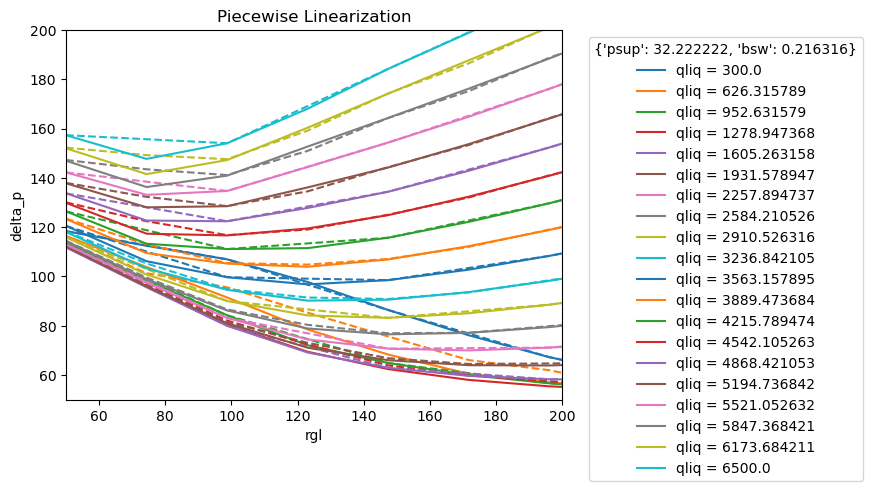

In [53]:
fixed_point = {
    'psup': 32.222222,
    'bsw': 0.216316,
}

df_ = df_riser[(df_riser['psup'] == fixed_point['psup']) & (df_riser['bsw'] == fixed_point['bsw'])]

for val in df_['qliq'].unique():
    df__ = df_[df_['qliq'] == val]
    p = plt.plot(df__['rgl'], df__['delta_p'], label=f"qliq = {val}")
    plt.plot(df__['rgl'], df__['delta_p_hat'], '--', color=p[0].get_color())
plt.xlabel('rgl')
plt.ylabel('delta_p')
plt.title(fixed_point)
plt.ylim(50,200)
plt.xlim(50,200)
plt.title('Piecewise Linearization')
plt.legend(title=fixed_point, bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

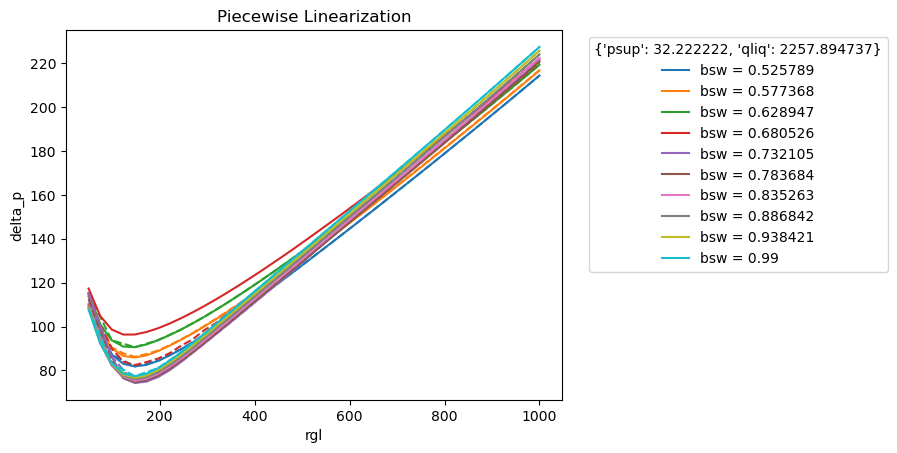

In [54]:
fixed_point = {
    'psup': 32.222222,
    'qliq': 2257.894737,
}

df_ = df_riser[(df_riser['psup'] == fixed_point['psup']) & (df_riser['qliq'] == fixed_point['qliq'])]

for val in df_['bsw'].unique():
    if val < .5:
        continue
    df__ = df_[df_['bsw'] == val]
    p = plt.plot(df__['rgl'], df__['delta_p'], label=f"bsw = {val}")
    plt.plot(df__['rgl'], df__['delta_p_hat'], '--', color=p[0].get_color())
plt.xlabel('rgl')
plt.ylabel('delta_p')
plt.title('Piecewise Linearization')
plt.legend(title=fixed_point, bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

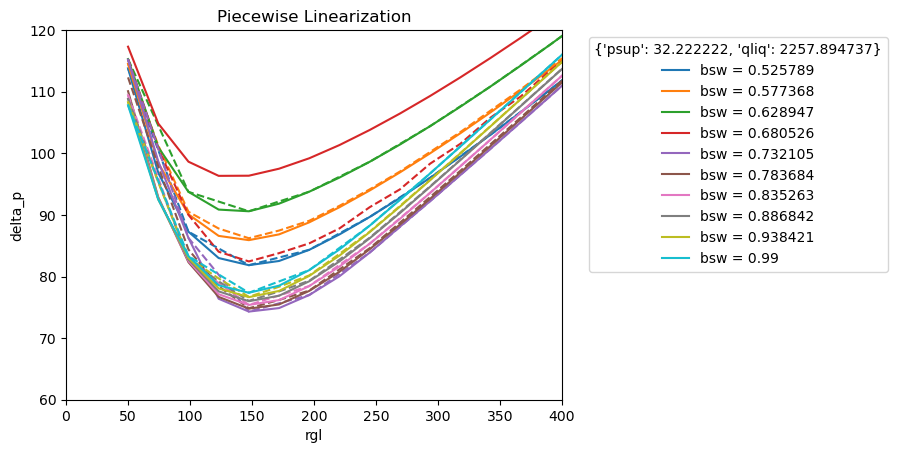

In [55]:
fixed_point = {
    'psup': 32.222222,
    'qliq': 2257.894737,
}

df_ = df_riser[(df_riser['psup'] == fixed_point['psup']) & (df_riser['qliq'] == fixed_point['qliq'])]

for val in df_['bsw'].unique():
    if val < .5:
        continue
    df__ = df_[df_['bsw'] == val]
    p = plt.plot(df__['rgl'], df__['delta_p'], label=f"bsw = {val}")
    plt.plot(df__['rgl'], df__['delta_p_hat'], '--', color=p[0].get_color())
plt.xlabel('rgl')
plt.ylabel('delta_p')
plt.title(fixed_point)
plt.title('Piecewise Linearization')
plt.legend(title=fixed_point, bbox_to_anchor=(1.04, 1), loc="upper left")
plt.ylim(60,120)
plt.xlim(0,400)
plt.show()